In [16]:
!pip install networkx
!pip install matplotlib
!pip install seaborn
!pip install scipy

  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)


# Graph Generation

In [7]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# --- Part 1: Define Organizational Foundation ---

# 1. Establish Organizational Parameters
N = 100  # Total number of employees
levels = {
    'C-Suite': 1,
    'Director': 4,
    'Manager': 15,
    'IC': 80
}
departments = ['Engineering', 'Marketing', 'Sales', 'HR']
avg_span_of_control = 5

# --- Display Parameters ---
print(f"Total Employees: {N}")
print(f"Hierarchy Levels: {list(levels.keys())}")
print(f"Departments: {departments}")



Total Employees: 100
Hierarchy Levels: ['C-Suite', 'Director', 'Manager', 'IC']
Departments: ['Engineering', 'Marketing', 'Sales', 'HR']


In [9]:
# 2. Generate Employee Roster
employee_levels = []
for level, count in levels.items():
    employee_levels.extend([level] * count)

# Assign departments - with some weighting
department_assignments = []
for level in employee_levels:
    if level == 'C-Suite':
        # C-Suite might be general, or we can assign them to a primary dept.
        department_assignments.append(np.random.choice(departments))
    else:
        # Skew assignments towards Engineering for ICs and Managers
        p = [0.5, 0.2, 0.2, 0.1] if level in ['IC', 'Manager'] else None
        department_assignments.append(np.random.choice(departments, p=p))


employees_df = pd.DataFrame({
    'employee_id': range(N),
    'level': employee_levels,
    'department': department_assignments,
    'tenure': np.random.randint(1, 11, size=N) # Tenure in years
})

# Add a 'manager_id' column to be filled in the next step
employees_df['manager_id'] = -1

print("Employee Roster:")
employees_df.head(20)



Employee Roster:


,employee_id,level,department,tenure,manager_id
0,0,C-Suite,Sales,6,-1
1,1,Director,Marketing,7,-1
2,2,Director,Sales,3,-1
3,3,Director,HR,8,-1
4,4,Director,HR,4,-1
5,5,Manager,Engineering,6,-1
6,6,Manager,HR,5,-1
7,7,Manager,Sales,6,-1
8,8,Manager,Marketing,8,-1
9,9,Manager,Engineering,1,-1


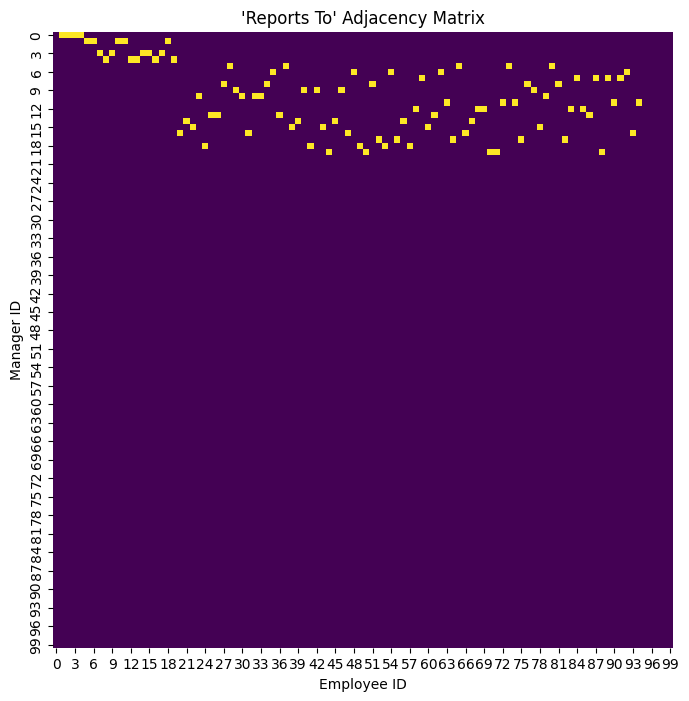

In [12]:
# --- Part 2: Generate Correlated Graphs as Adjacency Matrices ---

# 1. `reports to` Graph (A_reports)
A_reports = np.zeros((N, N), dtype=int)
level_keys = list(levels.keys())

# Helper to get employee indices for a given level
def get_employees_by_level(level_name):
    return employees_df[employees_df['level'] == level_name].index

# Assign managers from top to bottom
for i in range(len(level_keys) - 1):
    manager_level = level_keys[i]
    report_level = level_keys[i+1]

    manager_indices = get_employees_by_level(manager_level).to_numpy()
    report_indices = get_employees_by_level(report_level)

    # Create a list of available manager slots based on span of control
    manager_slots = np.repeat(manager_indices, avg_span_of_control)
    
    # Shuffle for randomness
    np.random.shuffle(manager_slots)
    manager_slots = manager_slots.tolist()

    # Assign reports to managers
    for report_idx in report_indices:
        if manager_slots:
            # Pop a manager from the available slots (pop is efficient)
            manager_idx = manager_slots.pop()
            
            # Create the link in the matrix and dataframe
            A_reports[manager_idx, report_idx] = 1
            employees_df.loc[report_idx, 'manager_id'] = manager_idx

# --- Visualize ---
plt.figure(figsize=(8, 8))
sns.heatmap(A_reports, cmap="viridis", cbar=False)
plt.title("'Reports To' Adjacency Matrix")
plt.xlabel("Employee ID")
plt.ylabel("Manager ID")
plt.show()



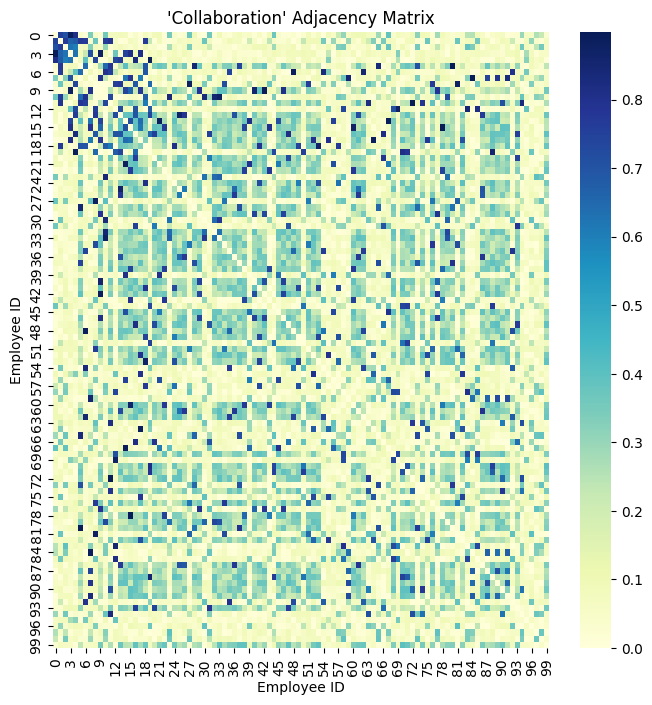

In [13]:
# 2. `collaboration` Graph (A_collab)
A_collab = np.zeros((N, N), dtype=float)

for i in range(N):
    for j in range(i, N): # Iterate through upper triangle to ensure symmetry
        if i == j:
            continue

        # Base random collaboration chance
        prob = np.random.rand() * 0.1

        manager_i = employees_df.loc[i, 'manager_id']
        manager_j = employees_df.loc[j, 'manager_id']
        
        dept_i = employees_df.loc[i, 'department']
        dept_j = employees_df.loc[j, 'department']

        # High probability: Manager-report relationship
        if A_reports[i, j] == 1 or A_reports[j, i] == 1:
            prob = 0.7 + np.random.rand() * 0.2 
        
        # High probability: Same team
        elif manager_i == manager_j and manager_i != -1:
            prob = 0.6 + np.random.rand() * 0.2
            
        # Medium probability: Same department
        elif dept_i == dept_j:
            prob = 0.2 + np.random.rand() * 0.2
        
        A_collab[i, j] = prob
        A_collab[j, i] = prob # Symmetric

# --- Visualize ---
plt.figure(figsize=(8, 8))
sns.heatmap(A_collab, cmap="YlGnBu")
plt.title("'Collaboration' Adjacency Matrix")
plt.xlabel("Employee ID")
plt.ylabel("Employee ID")
plt.show()



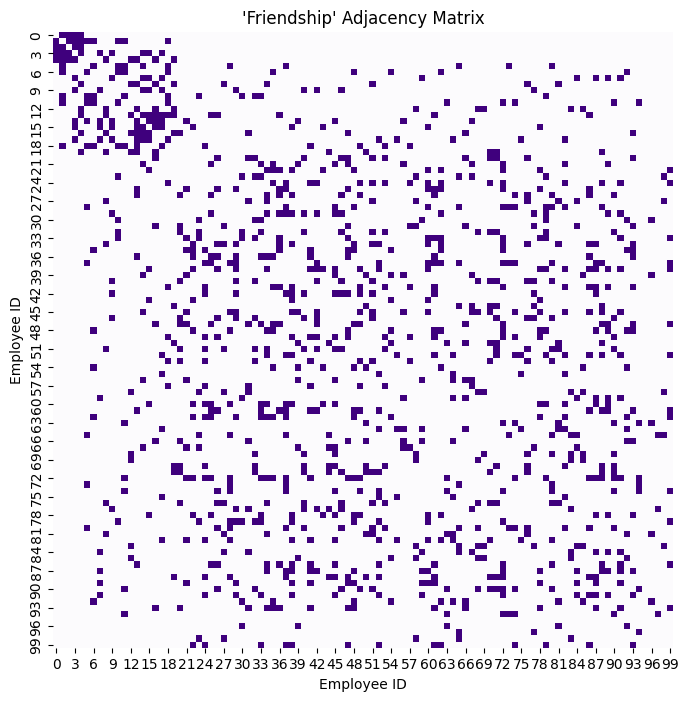

In [14]:
# 3. `friendship` Graph (A_friend)
A_friend = np.zeros((N, N), dtype=int)
friendship_threshold = 0.7

for i in range(N):
    for j in range(i, N):
        if i == j:
            continue

        # Start with collaboration score
        score = A_collab[i, j]

        # Add bonus for being peers at the same level
        if employees_df.loc[i, 'level'] == employees_df.loc[j, 'level']:
            score += 0.2
        
        # Add bonus for being in the same department
        if employees_df.loc[i, 'department'] == employees_df.loc[j, 'department']:
            score += 0.1

        # Add bonus for similar tenure
        tenure_diff = abs(employees_df.loc[i, 'tenure'] - employees_df.loc[j, 'tenure'])
        score += max(0, 0.1 - tenure_diff * 0.02)
        
        if score > friendship_threshold:
            A_friend[i, j] = 1
            A_friend[j, i] = 1

# --- Visualize ---
plt.figure(figsize=(8, 8))
sns.heatmap(A_friend, cmap="Purples", cbar=False)
plt.title("'Friendship' Adjacency Matrix")
plt.xlabel("Employee ID")
plt.ylabel("Employee ID")
plt.show()



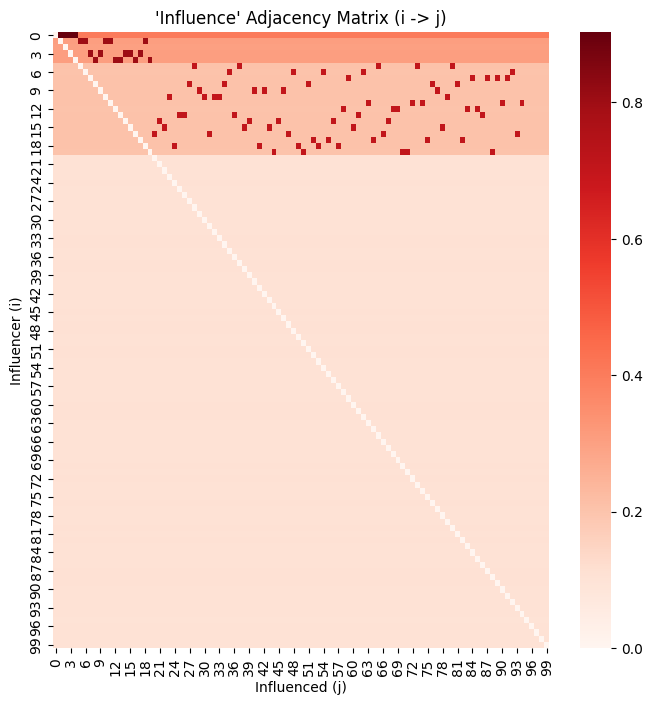

In [17]:
# 4. `influence` Graph (A_influence)
A_influence = np.zeros((N, N), dtype=float)

# --- Calculate Informal Influence using NetworkX ---
# Create a combined social graph from collaboration and friendship
social_graph_matrix = A_collab + A_friend
G_social = nx.from_numpy_array(social_graph_matrix)

# Calculate PageRank as a measure of informal influence
pagerank = nx.pagerank(G_social, weight='weight')
informal_influence = pd.Series(pagerank)

# --- Combine Formal and Informal Influence ---
level_influence_map = { 'C-Suite': 0.4, 'Director': 0.3, 'Manager': 0.2, 'IC': 0.1 }

for i in range(N): # The influencer
    for j in range(N): # The influenced
        if i == j:
            continue
        
        influence_score = 0
        
        # Formal influence from hierarchy
        if A_reports[i, j] == 1:
            influence_score += 0.5 # Direct manager has strong influence
        
        # Base influence from level
        influencer_level = employees_df.loc[i, 'level']
        influence_score += level_influence_map.get(influencer_level, 0)
        
        # Informal influence from social network centrality
        influence_score += informal_influence[i] * 0.5
        
        A_influence[i, j] = np.clip(influence_score, 0, 1)


# --- Visualize ---
plt.figure(figsize=(8, 8))
sns.heatmap(A_influence, cmap="Reds")
plt.title("'Influence' Adjacency Matrix (i -> j)")
plt.xlabel("Influenced (j)")
plt.ylabel("Influencer (i)")
plt.show()



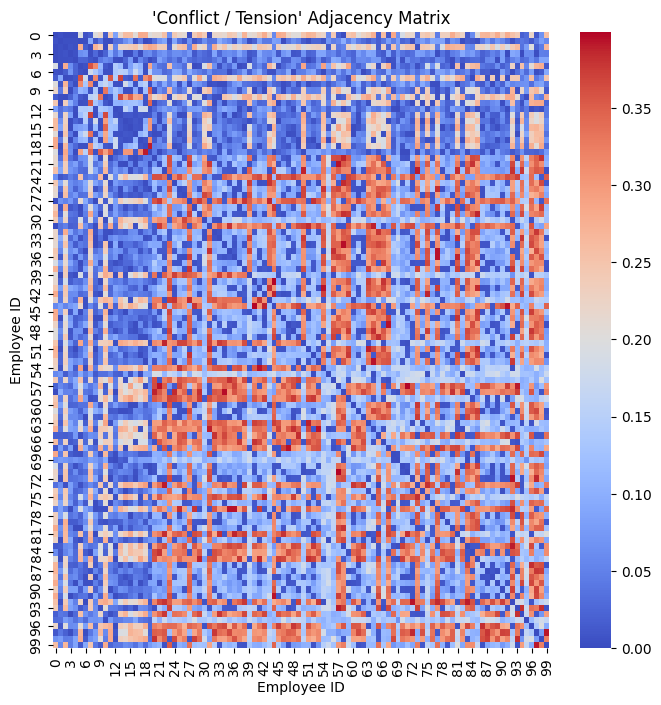

In [18]:
# 5. `conflict / tension` Graph (A_conflict)
A_conflict = np.zeros((N, N), dtype=float)

# Define departments that might have higher tension
competing_depts = {
    'Sales': ['Engineering', 'Marketing'],
    'Engineering': ['Sales', 'Marketing']
}

for i in range(N):
    for j in range(i, N):
        if i == j:
            continue
            
        prob = np.random.rand() * 0.1 # Base tension
        
        # Increase for peers at same level (rivalry)
        if employees_df.loc[i, 'level'] == employees_df.loc[j, 'level']:
            prob += 0.1
            
        # Increase for competing departments
        dept_i = employees_df.loc[i, 'department']
        dept_j = employees_df.loc[j, 'department']
        if dept_j in competing_depts.get(dept_i, []):
            prob += 0.2
            
        # Decrease significantly for friendship
        if A_friend[i, j] == 1:
            prob *= 0.1
        
        # Decrease for strong collaboration
        prob *= (1 - A_collab[i, j])
        
        final_prob = np.clip(prob, 0, 1)
        A_conflict[i, j] = final_prob
        A_conflict[j, i] = final_prob

# --- Visualize ---
plt.figure(figsize=(8, 8))
sns.heatmap(A_conflict, cmap="coolwarm")
plt.title("'Conflict / Tension' Adjacency Matrix")
plt.xlabel("Employee ID")
plt.ylabel("Employee ID")
plt.show()

